In [63]:
import numpy as np
import pandas as pd

import seaborn as sns

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

In [64]:
pd.set_option("display.max_columns", None)

# Process data and drop ID and Semer

In [89]:
data = pd.read_excel("../../data/raw/drug_consumption.xls")

drugs = data.columns[13:]
for drug in drugs: 
    data[drug] = data[drug].str.replace('CL', '').astype('int')

data.query('Semer == 0', inplace = True)

data.drop('ID', axis=1, inplace=True)
data.drop('Semer', axis=1, inplace=True)

# Create bin for illegal drus 1

In [90]:
alcohol = ['Alcohol']

nicotine = ['Nicotine']

illegal_drugs1 = ['Cannabis', 'Legalh', 'LSD', 'Shrooms', 
                  'Amphet', 'Amyl', 'Ecstasy', 'Ketamine', 
                  'Coke']

illegal_drugs2 = ['Meth', 'Benzos', 'Heroin', 'Crack']

In [91]:
borders = [5, 3, 3, 3, 3, 3, 3, 3, 3]
drug_zip = list(zip(borders, illegal_drugs1))

for b, drug in zip(borders, illegal_drugs1):
    data[drug+'_bin'] = [1 if d > b else 0 for d in data[drug].values]

In [92]:
data.iloc[:, -9:].sum(axis=0)

Cannabis_bin    458
Legalh_bin      240
LSD_bin         163
Shrooms_bin     156
Amphet_bin      237
Amyl_bin         41
Ecstasy_bin     238
Ketamine_bin     77
Coke_bin        157
dtype: int64

In [93]:
data['illegal_drugs_1'] = data.iloc[:, -9:].sum(axis=1)

data['illegal_drugs_1'] = [1 if ill > 0 else 0 for ill in data.illegal_drugs_1.values]
data.illegal_drugs_1.value_counts()

0    1078
1     799
Name: illegal_drugs_1, dtype: int64

In [94]:
df, df_test = train_test_split(data, test_size=0.33, random_state=1, stratify=data.illegal_drugs_1, shuffle=True)

print(df.illegal_drugs_1.value_counts()/df.shape[0])
print(df_test.illegal_drugs_1.value_counts()/df_test.shape[0])

0    0.574383
1    0.425617
Name: illegal_drugs_1, dtype: float64
0    0.574194
1    0.425806
Name: illegal_drugs_1, dtype: float64


In [95]:
X = df.iloc[:, :12]

In [96]:
y = df.illegal_drugs_1

# Models
- Naive Bayes
- Decision Tree
- Random Forests
- KNN
- Logreg
- SVM
- Assemble Methods (AdaBoost, XGBoost)

# Naive Bayes - Baseline

In [73]:
clf = GaussianNB()
#clf.fit(X, y)

In [74]:
f1_score = cross_val_score(clf, X, y, scoring='f1')
print(f1_score)

[0.84716157 0.82142857 0.82969432 0.77922078 0.80686695]


In [75]:
y_pred_NB_drugs1 = cross_val_predict(clf,X, y, cv=5)

In [76]:
print(classification_report(y, y_pred_NB_drugs1))
print(confusion_matrix(y, y_pred_NB_drugs1))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       549
           1       0.82      0.81      0.82       577

    accuracy                           0.81      1126
   macro avg       0.81      0.81      0.81      1126
weighted avg       0.81      0.81      0.81      1126

[[448 101]
 [109 468]]


## SMOTE Naive Bayes

In [77]:
df.illegal_drugs_1.value_counts()/df.shape[0]

1    0.512433
0    0.487567
Name: illegal_drugs_1, dtype: float64

In [78]:
Counter(y)

Counter({0: 549, 1: 577})

In [79]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

In [80]:
clf = GaussianNB()

In [81]:
y_pred_NB_drugs1_smote = cross_val_predict(clf,X_smote, y_smote, cv=5)

In [82]:
print(classification_report(y_smote, y_pred_NB_drugs1_smote))
print(confusion_matrix(y_smote, y_pred_NB_drugs1_smote))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       577
           1       0.82      0.81      0.82       577

    accuracy                           0.82      1154
   macro avg       0.82      0.82      0.82      1154
weighted avg       0.82      0.82      0.82      1154

[[474 103]
 [109 468]]


# Decision Tree

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       577
           1       0.79      0.75      0.77       577

    accuracy                           0.78      1154
   macro avg       0.78      0.78      0.78      1154
weighted avg       0.78      0.78      0.78      1154



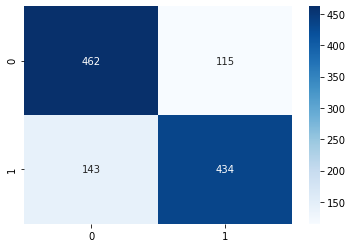

In [83]:
dtree = DecisionTreeClassifier(max_depth=10)
y_pred_drugs1_dt = cross_val_predict(dtree, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_dt)
print(classification_report(y_smote, y_pred_drugs1_dt))
sns.heatmap(cm, annot=True,
            cmap='Blues', fmt='.0f');

# Random Forest

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       577
           1       0.83      0.84      0.84       577

    accuracy                           0.84      1154
   macro avg       0.84      0.84      0.84      1154
weighted avg       0.84      0.84      0.84      1154



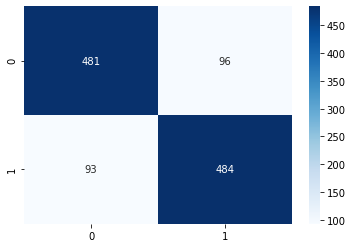

In [84]:
rf = RandomForestClassifier(n_estimators = 200, random_state=10)#, class_weight="balanced")
y_pred_drugs1_rf = cross_val_predict(rf, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_rf)
print(classification_report(y_smote, y_pred_drugs1_rf))
sns.heatmap(cm, annot=True,
            cmap='Blues', fmt='.0f');

In [98]:
rnc = RandomForestClassifier()

parameters = { 
    'n_estimators': np.arange(20, 3000, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(1, 20, 1),
    'min_samples_leaf' : np.arange(2, 20, 2),
    'min_samples_split' : np.arange(2, 20, 2),
    'criterion' :['gini', 'entropy']
}

scorer = {
          'prec': 'precision', 
          'recall': 'recall',
          'f1': 'f1',
        #  'fbeta': make_scorer(fbeta_score, beta=5, average = "weighted")
         }

grid_rnc = RandomizedSearchCV(rnc, parameters, scoring=scorer, refit='f1') 
grid_rnc.fit(X_smote,y_smote) 
best_rnc = grid_rnc.best_estimator_ 
best_scores = grid_rnc.cv_results_
best_param = grid_rnc.best_estimator_

In [99]:
best_rnc

RandomForestClassifier(max_depth=16, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=2940)

In [100]:
y_pred_rnc_train = best_rnc.predict(X)
print(classification_report(y, y_pred_rnc_train))

              precision    recall  f1-score   support

           0       0.91      0.79      0.84       722
           1       0.76      0.89      0.82       535

    accuracy                           0.83      1257
   macro avg       0.83      0.84      0.83      1257
weighted avg       0.84      0.83      0.83      1257



# Logistische Regression

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       577
           1       0.85      0.80      0.83       577

    accuracy                           0.83      1154
   macro avg       0.83      0.83      0.83      1154
weighted avg       0.83      0.83      0.83      1154



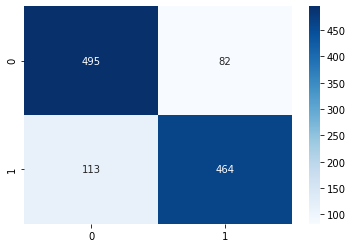

In [87]:
logreg = LogisticRegression(max_iter=1000, solver="liblinear")
y_pred_drugs1_lr = cross_val_predict(logreg, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_lr)
print(classification_report(y_smote, y_pred_drugs1_lr))
sns.heatmap(cm, annot=True,
            cmap='Blues', fmt='.0f');

#  KNN

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       639
           1       0.85      0.74      0.79       639

    accuracy                           0.81      1278
   macro avg       0.81      0.81      0.80      1278
weighted avg       0.81      0.81      0.80      1278



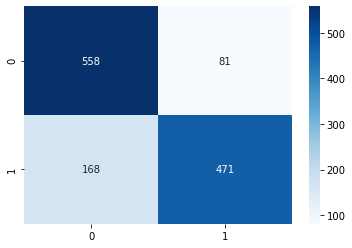

In [440]:
knn = KNeighborsClassifier(n_neighbors=8)
y_pred_drugs1_knn = cross_val_predict(knn, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_knn)
print(classification_report(y_smote, y_pred_drugs1_knn))
sns.heatmap(cm, annot=True,
            cmap='Blues', fmt='.0f');

# Support Vector Machines

In [441]:
sv = svm.SVC(kernel='rbf')

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       639
           1       0.82      0.80      0.81       639

    accuracy                           0.81      1278
   macro avg       0.81      0.81      0.81      1278
weighted avg       0.81      0.81      0.81      1278



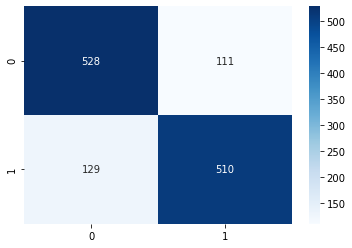

In [442]:
y_pred_drugs1_svm = cross_val_predict(sv, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_svm)
print(classification_report(y_smote, y_pred_drugs1_svm))
sns.heatmap(cm, annot=True,
            cmap='Blues', fmt='.0f');

# XG Boost

In [86]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
y_pred_drugs1_XG = cross_val_predict(xgb, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_drugs1_XG)
print(classification_report(y_smote, y_pred_drugs1_XG))
print(cm)

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       577
           1       0.81      0.82      0.82       577

    accuracy                           0.82      1154
   macro avg       0.82      0.82      0.82      1154
weighted avg       0.82      0.82      0.82      1154

[[470 107]
 [106 471]]


# AdaBoost

In [30]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state = 101)
y_pred_ada = cross_val_predict(ada, X_smote, y_smote, cv=5)
cm = confusion_matrix(y_smote, y_pred_ada)
print(classification_report(y_smote, y_pred_ada))
print(cm)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       640
           1       0.83      0.80      0.81       640

    accuracy                           0.82      1280
   macro avg       0.82      0.82      0.82      1280
weighted avg       0.82      0.82      0.82      1280

[[534 106]
 [129 511]]


# F1 beta score, weighting of parameters, feature selection

# Evaluation

In [101]:
X_test = df_test.iloc[:, :12]
y_test = df_test.illegal_drugs_1

In [102]:
y_pred_rf_test = grid_rnc.best_estimator_.predict(X_test)

              precision    recall  f1-score   support

           0       0.93      0.74      0.82       356
           1       0.72      0.92      0.81       264

    accuracy                           0.82       620
   macro avg       0.83      0.83      0.82       620
weighted avg       0.84      0.82      0.82       620



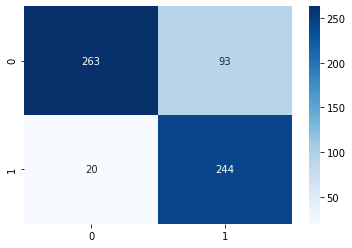

In [103]:
cm = confusion_matrix(y_test, y_pred_rf_test)
print(classification_report(y_test, y_pred_rf_test))
sns.heatmap(cm, annot=True,
            cmap='Blues', fmt='.0f');

In [106]:
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

Text(0, 0.5, 'Precision')

<Figure size 720x720 with 0 Axes>

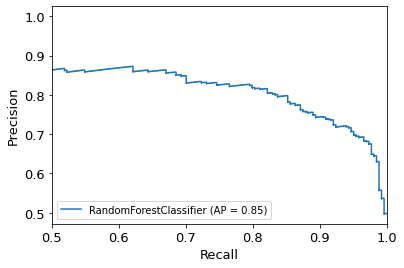

In [111]:
fig = plt.figure(figsize=(10,10))
disp = plot_precision_recall_curve(grid_rnc.best_estimator_, X_test, y_test)
plt.xlim((0.5,1))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Recall', fontsize=13)
plt.ylabel('Precision', fontsize=13)

In [113]:
features = list(X.columns)

fi_rf = pd.DataFrame({'feature': features,
                   'importance': grid_rnc.best_estimator_.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_rf.head(5)

,feature,importance
3,Country,0.295830
11,SS,0.147318
0,Age,0.137096
7,Oscore,0.093260
9,Cscore,0.066403
